### This notebook generates common key performance indicators (KPI) in gaming for a subset of the World of Warcraft (WOW) dataset on [Kaggle](https://www.kaggle.com/mylesoneill/warcraft-avatar-history):

In [859]:
# Load all packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import colors
from matplotlib import pyplot
from bokeh.io import output_notebook
from bokeh.charts import TimeSeries, show,Scatter
from bokeh.models import BoxSelectTool

output_notebook()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Loading BokehJS ...

### The following code preprocesses the dataset for further analysis

In [860]:
# create dataframe table
ww=pd.read_csv("./warcraft-avatar-history/wowah_data.csv")

In [861]:
# Inspect
ww.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [862]:
# Rename columns to remove extra space
ww.rename(columns={' level':'level',' race':'race',' charclass': 'charclass', ' zone':'zone',' guild':'guild',' timestamp':'timestamp'}, inplace=True)

In [863]:
# Summarize data types of columns 
ww.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
char         int64
level        int64
race         object
charclass    object
zone         object
guild        int64
timestamp    object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


In [864]:
# Take a subsample of users and their associated values from the original dataframe to reduce processing 
# time of data analysis.
# Note: The following analysis will produce different results from similar analyses on the entire dataframe, especially
# for very small subsamples.
unique_char=pd.Series(ww.char.unique())
sample_unique_char=list(unique_char.sample(frac=0.03))
ww_char_sub=ww[ww['char'].isin(sample_unique_char)]

In [865]:
# Convert timestamp and date to datetime format and generate columns for date, month, day, hour
ww_char_sub.loc[:,'timestamp']=pd.to_datetime(ww_char_sub['timestamp'])

ww_char_sub.loc[:,'date']=ww_char_sub['timestamp'].dt.date
ww_char_sub.loc[:,'month_int']=ww_char_sub['timestamp'].dt.month
ww_char_sub.loc[:,'day']=ww_char_sub['timestamp'].dt.day
ww_char_sub.loc[:,'hour']=ww_char_sub['timestamp'].dt.hour

m={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
ww_char_sub.loc[:,'month']=ww_char_sub['month_int'].map(m)

ww_char_sub=ww_char_sub.sort_values('timestamp', ascending=True)

ww_char_sub.loc[:,'date']=pd.to_datetime(ww_char_sub['date'])

In [866]:
# Inspect
ww_char_sub.head()

,char,level,race,charclass,zone,guild,timestamp,date,month_int,day,hour,month
25,753,70,Orc,Hunter,Orgrimmar,53,2008-01-01 00:02:24,2008-01-01,1,1,0,Jan
97,3275,70,Tauren,Shaman,Sethekk Halls,19,2008-01-01 00:03:09,2008-01-01,1,1,0,Jan
211,24674,70,Undead,Mage,Eye of the Storm,101,2008-01-01 00:04:26,2008-01-01,1,1,0,Jan
280,23248,70,Undead,Warrior,Shattrath City,243,2008-01-01 00:04:46,2008-01-01,1,1,0,Jan
293,65477,15,Blood Elf,Paladin,Ghostlands,-1,2008-01-01 00:04:57,2008-01-01,1,1,0,Jan


In [867]:
# Inpsect 
print ww_char_sub.shape

(312993, 12)


In [868]:
# Include the date that a user likely downloaded the game
add=ww_char_sub.groupby('char').agg({'timestamp':np.min}).reset_index()
add=add.rename(columns={'timestamp':'beg_date'})
ww_char_sub=ww_char_sub.merge(add, how="left", on="char")
print ww_char_sub.shape

(312993, 13)


In [871]:
# Include the days since install (dsi) as a column and convert install date to datetime format
ww_char_sub['dsi']=pd.Series([i.days for i in (ww_char_sub.timestamp-ww_char_sub.beg_date)])
ww_char_sub.loc[:,'beg_date']=ww_char_sub['beg_date'].dt.date

In [872]:
# Inspect
ww_char_sub.head()

,char,level,race,charclass,zone,guild,timestamp,date,month_int,day,hour,month,beg_date,dsi
0,753,70,Orc,Hunter,Orgrimmar,53,2008-01-01 00:02:24,2008-01-01,1,1,0,Jan,2008-01-01,0
1,3275,70,Tauren,Shaman,Sethekk Halls,19,2008-01-01 00:03:09,2008-01-01,1,1,0,Jan,2008-01-01,0
2,24674,70,Undead,Mage,Eye of the Storm,101,2008-01-01 00:04:26,2008-01-01,1,1,0,Jan,2008-01-01,0
3,23248,70,Undead,Warrior,Shattrath City,243,2008-01-01 00:04:46,2008-01-01,1,1,0,Jan,2008-01-01,0
4,65477,15,Blood Elf,Paladin,Ghostlands,-1,2008-01-01 00:04:57,2008-01-01,1,1,0,Jan,2008-01-01,0


In [873]:
# Inspect
ww_char_sub.shape

(312993, 14)

In [874]:
# Break levels into ranges
ww_char_sub['level_range']=pd.cut(ww_char_sub['level'],[0,60,70,80])

### The following code prepares the data to plot total daily active users (DAU) over time

In [875]:
# Count unique users by date
dau=ww_char_sub.groupby(['date',])['char'].nunique().reset_index()

In [876]:
# Inpsect
dau.head()

,date,char
0,2008-01-01,81
1,2008-01-02,68
2,2008-01-03,62
3,2008-01-04,68
4,2008-01-05,85


In [877]:
# Set date as index
dau.set_index('date',inplace=True)

Plot comments:

A negative trend overall is observed in the DAU count over 2008.

The most noticable drop in DAU's is observed in early May, but quick, sharp drops also occur in late January, late March, early April, middle of June, and middle of November.

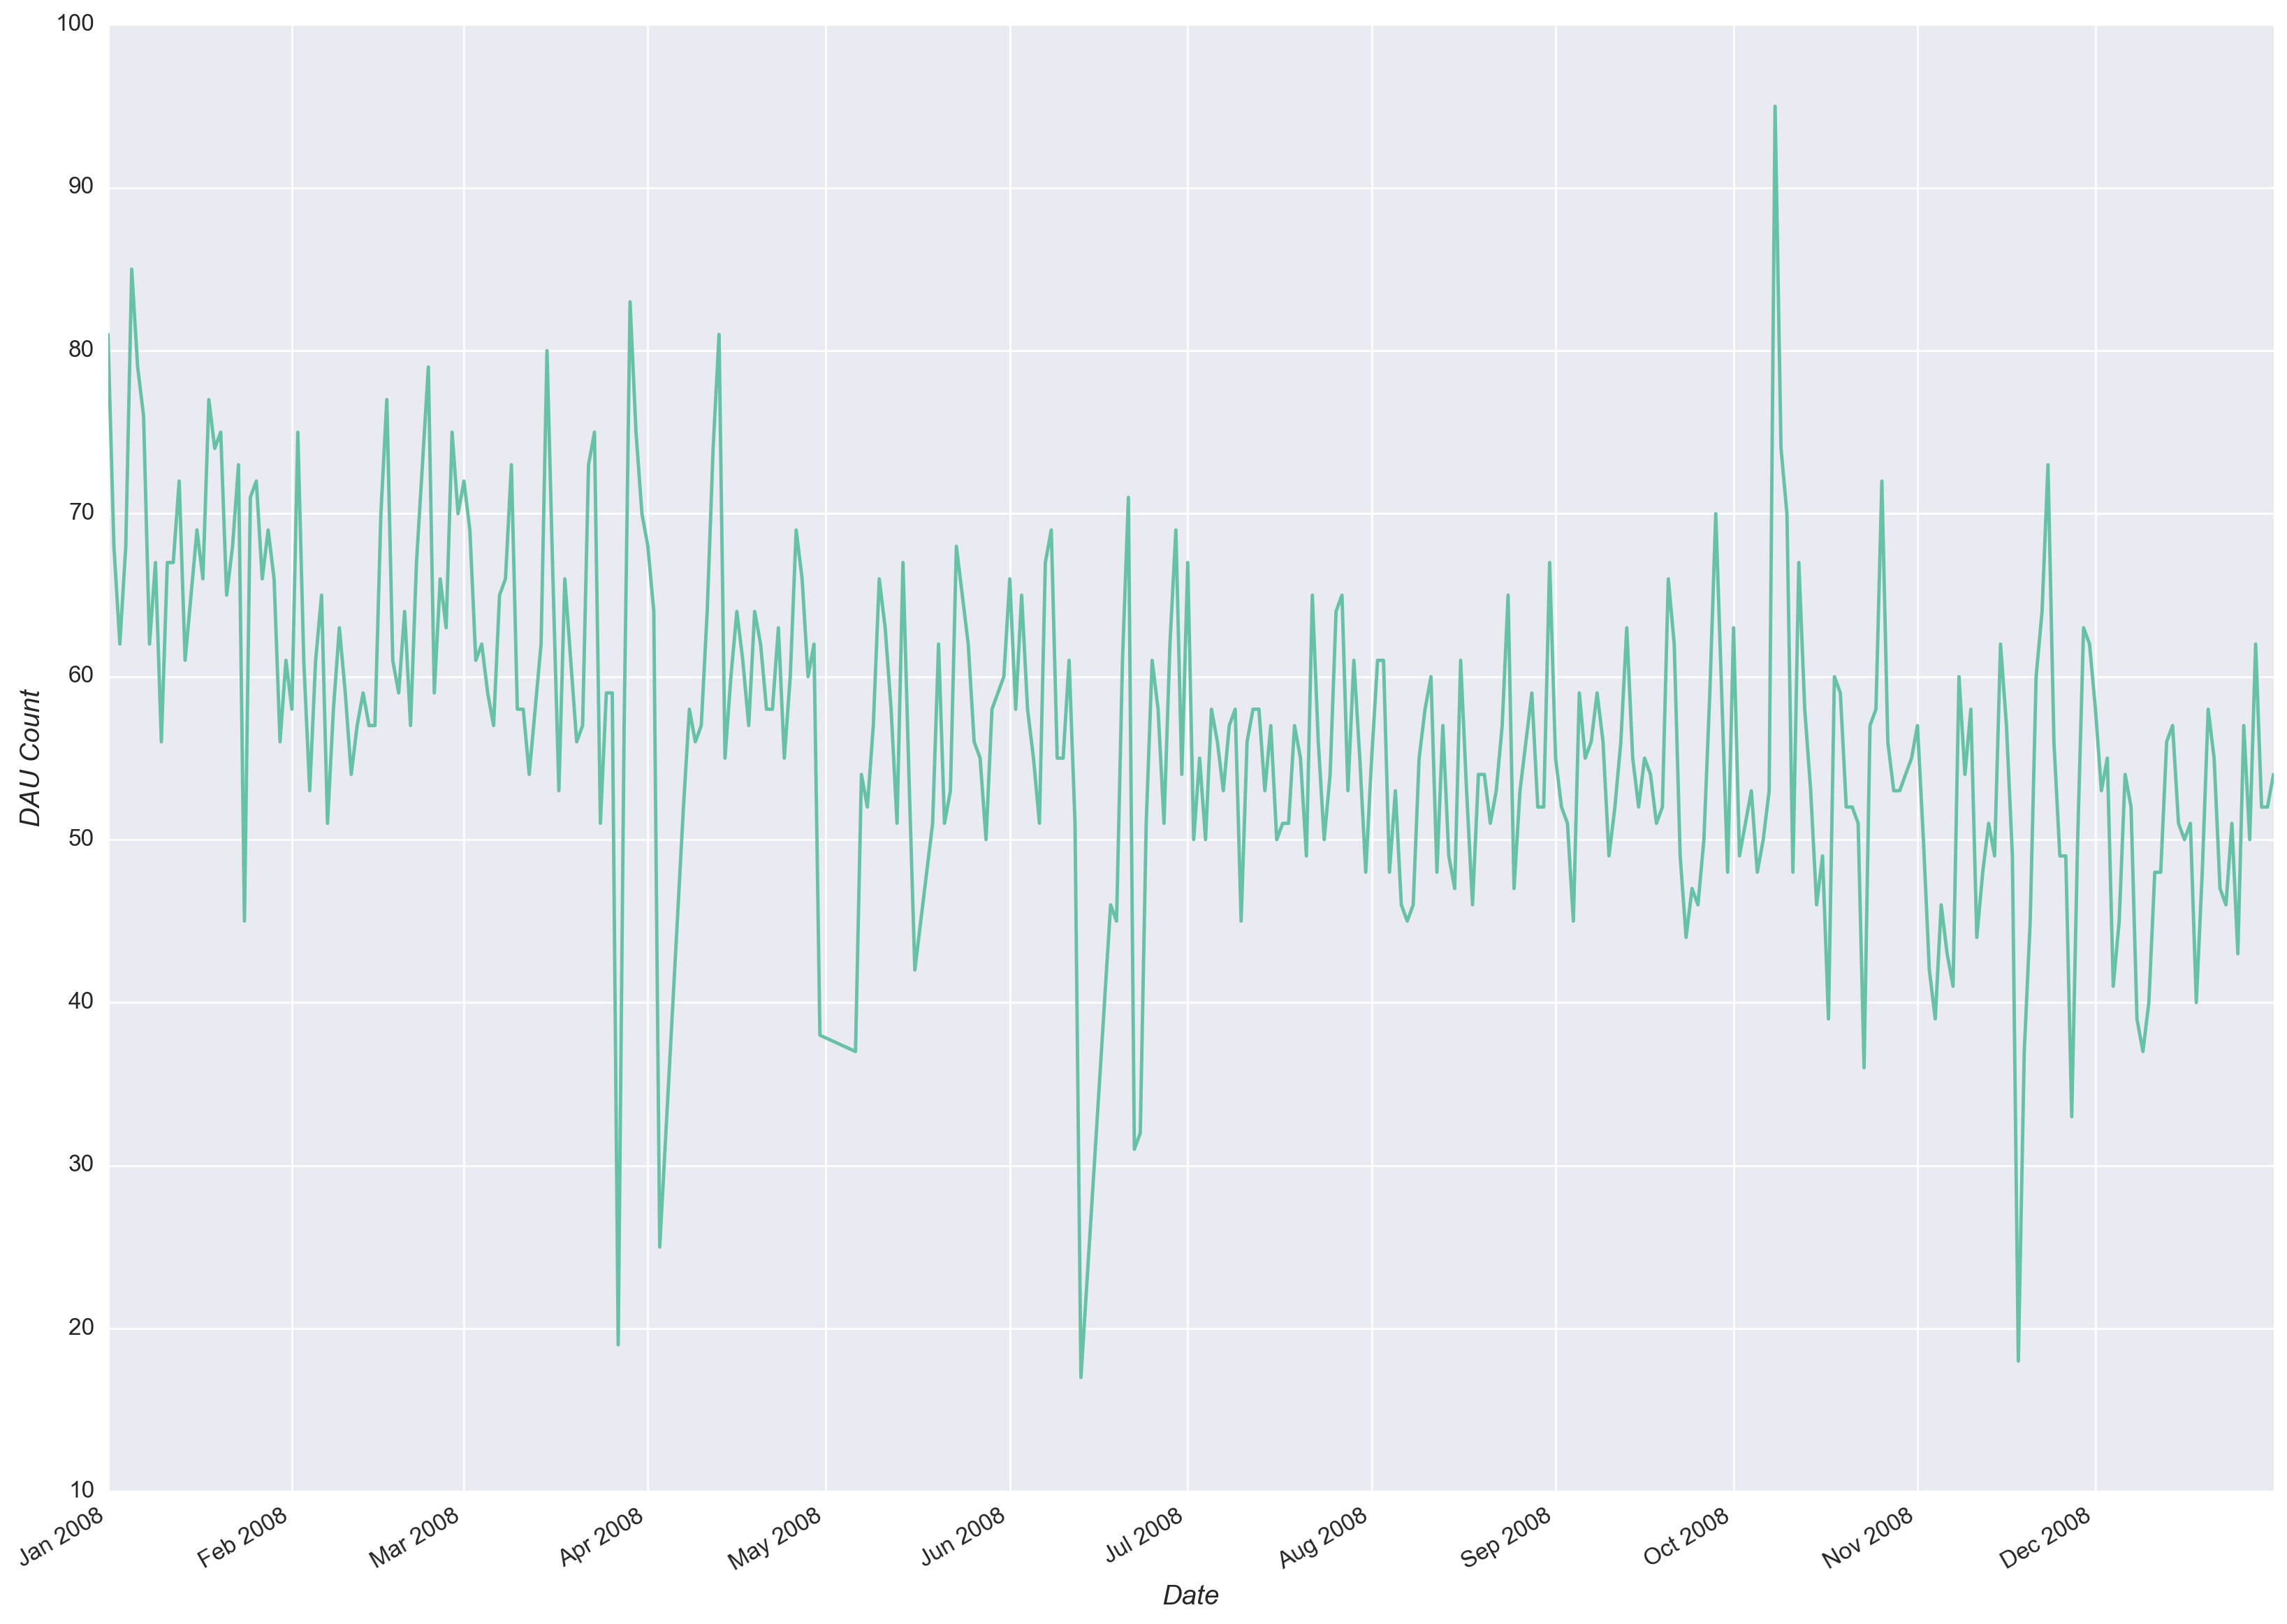

In [878]:
# Plot DAU
colors=sns.color_palette("Set2", 10)

fig, ax = plt.subplots(1,1, figsize=(20,15))

dau.loc[:,['char']].plot(color=colors[0],ax=ax,legend=False)

ax.set_ylabel("DAU Count",style='italic',fontsize=14)
ax.set_xlabel("Date",style='italic',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

pyplot.show()

### The following code prepares the data to plot total daily active users over time by level of user

In [879]:
# Count unique users by date and range of levels
dau_level=ww_char_sub.groupby(['date','level_range',])['char'].nunique().reset_index()

In [880]:
# Add a column to the dau_level dataframe that includes the sum of all unique users by date
print dau_level.shape
add=dau_level.groupby('date')['char'].agg({'char':np.sum}).reset_index()
add=add.rename(columns={'char':'percent_dau'})
dau_level=dau_level.merge(add,how='left',on="date")
print dau_level.shape

(747, 3)
(747, 4)


In [881]:
# Inspect
dau_level.head()

,date,level_range,char,percent_dau
0,2008-01-01,"(0, 60]",29,81
1,2008-01-01,"(60, 70]",52,81
2,2008-01-02,"(0, 60]",19,68
3,2008-01-02,"(60, 70]",49,68
4,2008-01-03,"(0, 60]",17,62


In [882]:
# Calculate the percent of DAU out of all DAU for the day
dau_level.loc[:,'percent_dau']=(dau_level['char']*100.0)/dau_level['percent_dau']

dau_level=dau_level.rename(columns={'char':'dau'})

In [883]:
# Inspect
dau_level.head()

,date,level_range,dau,percent_dau
0,2008-01-01,"(0, 60]",29,35.802469
1,2008-01-01,"(60, 70]",52,64.197531
2,2008-01-02,"(0, 60]",19,27.941176
3,2008-01-02,"(60, 70]",49,72.058824
4,2008-01-03,"(0, 60]",17,27.419355


Plot comments:

The DAU counts for the highest levels (70-80) begin in late Nov 2008. 

High levels have relatively high DAU's. Also, the long-term negative trend as observed above occurs mostly due to a long-term decline in DAU at high levels (60-70). 

The most noticable drop in DAU's is observed for all levels in early May, but quick, sharp drops also occur in late January, late March, early April, middle of June, and middle of November.

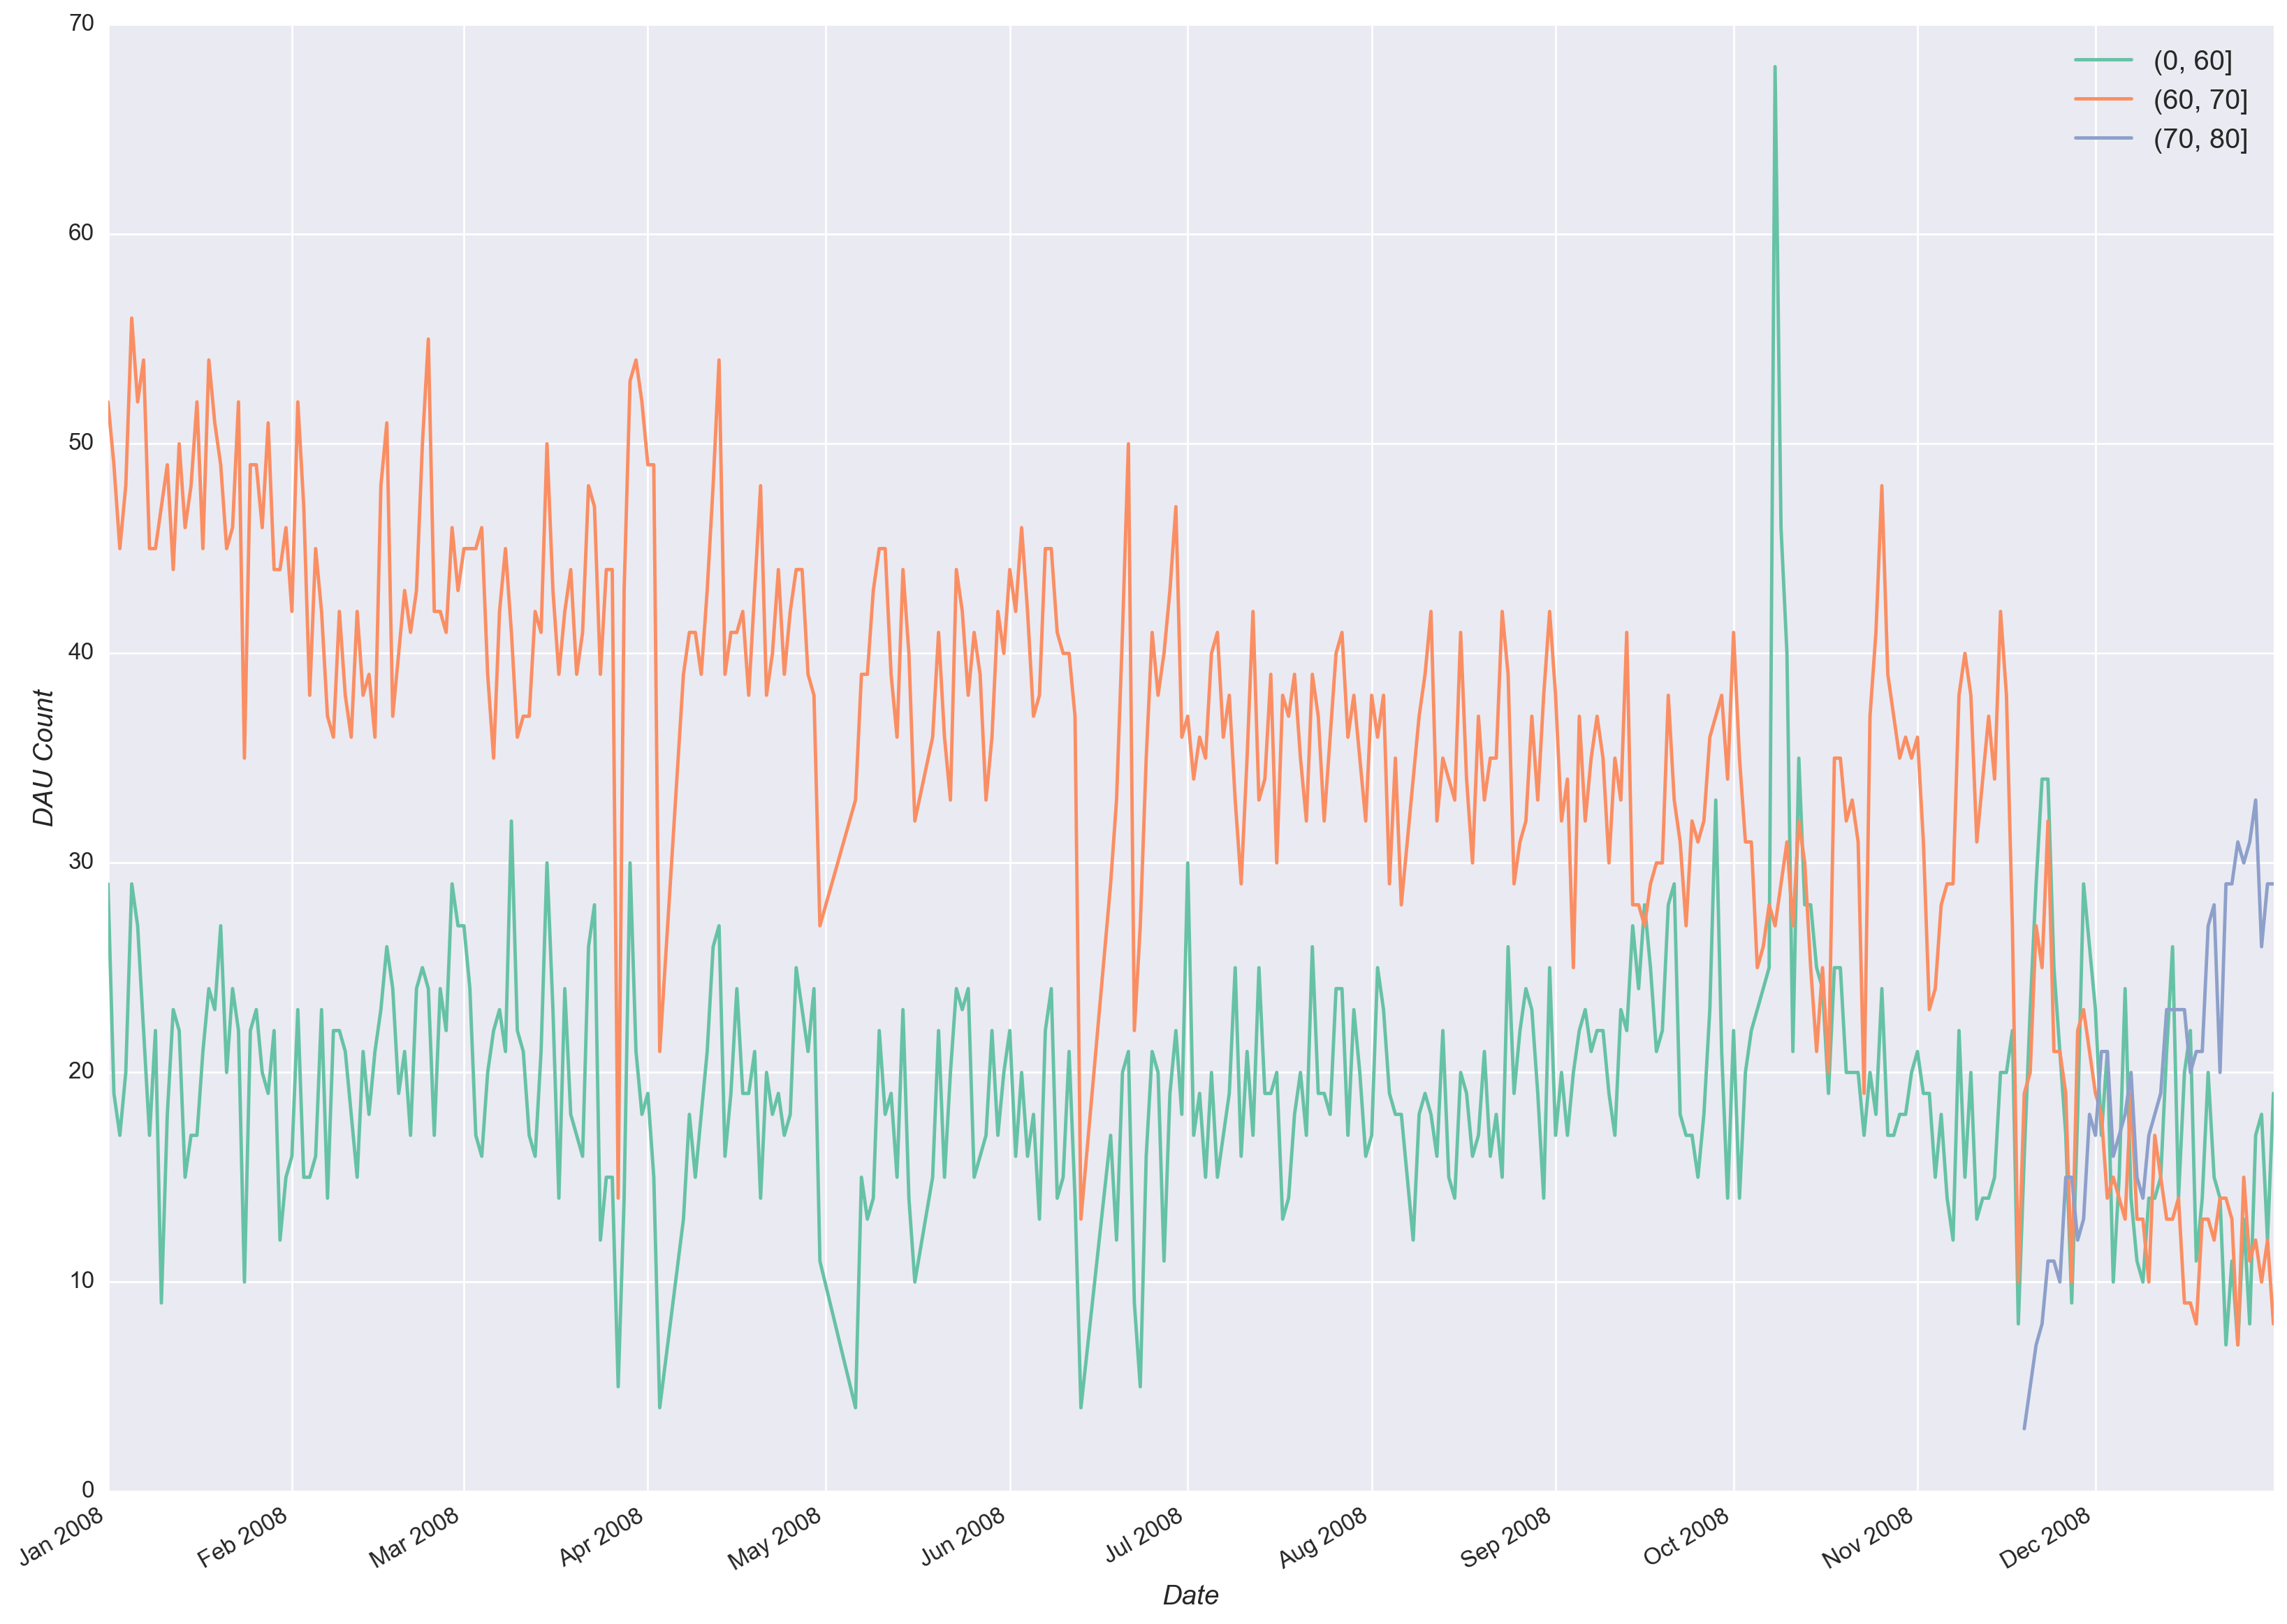

In [884]:
# Plot DAU 
# Note: DAU percents that were similar over time were grouped. The grouping resulted in three distinct groups. 
fig, ax = plt.subplots(1,1, figsize=(20,15))


levels=list(dau_level['level_range'].unique())

for i,item in enumerate(levels):
    temp=dau_level[dau_level['level_range']==item]
    temp.set_index('date',inplace=True)
    temp.loc[:,['dau']].plot(color=colors[i],ax=ax)

ax.legend(levels,loc="best",fontsize='x-large')


# # plt.setp(labels, rotation=90) 
ax.set_ylabel("DAU Count",style='italic',fontsize=14)
ax.set_xlabel("Date",style='italic',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

pyplot.show()

Plot comments:

Again, high levels have relatively high percent of DAU's. 

The most noticable drop as discussed in the previous figure is reflected in the DAU percent for levels 0-60, but not levels 60-70. In fact, the DAU percent for levels 0-60 appears to roughly mirror the inverse of the trend of the DAU percent for levels 60-70. Similar observations at other observed drops in the DAU count plots are not observed in the plot below. 

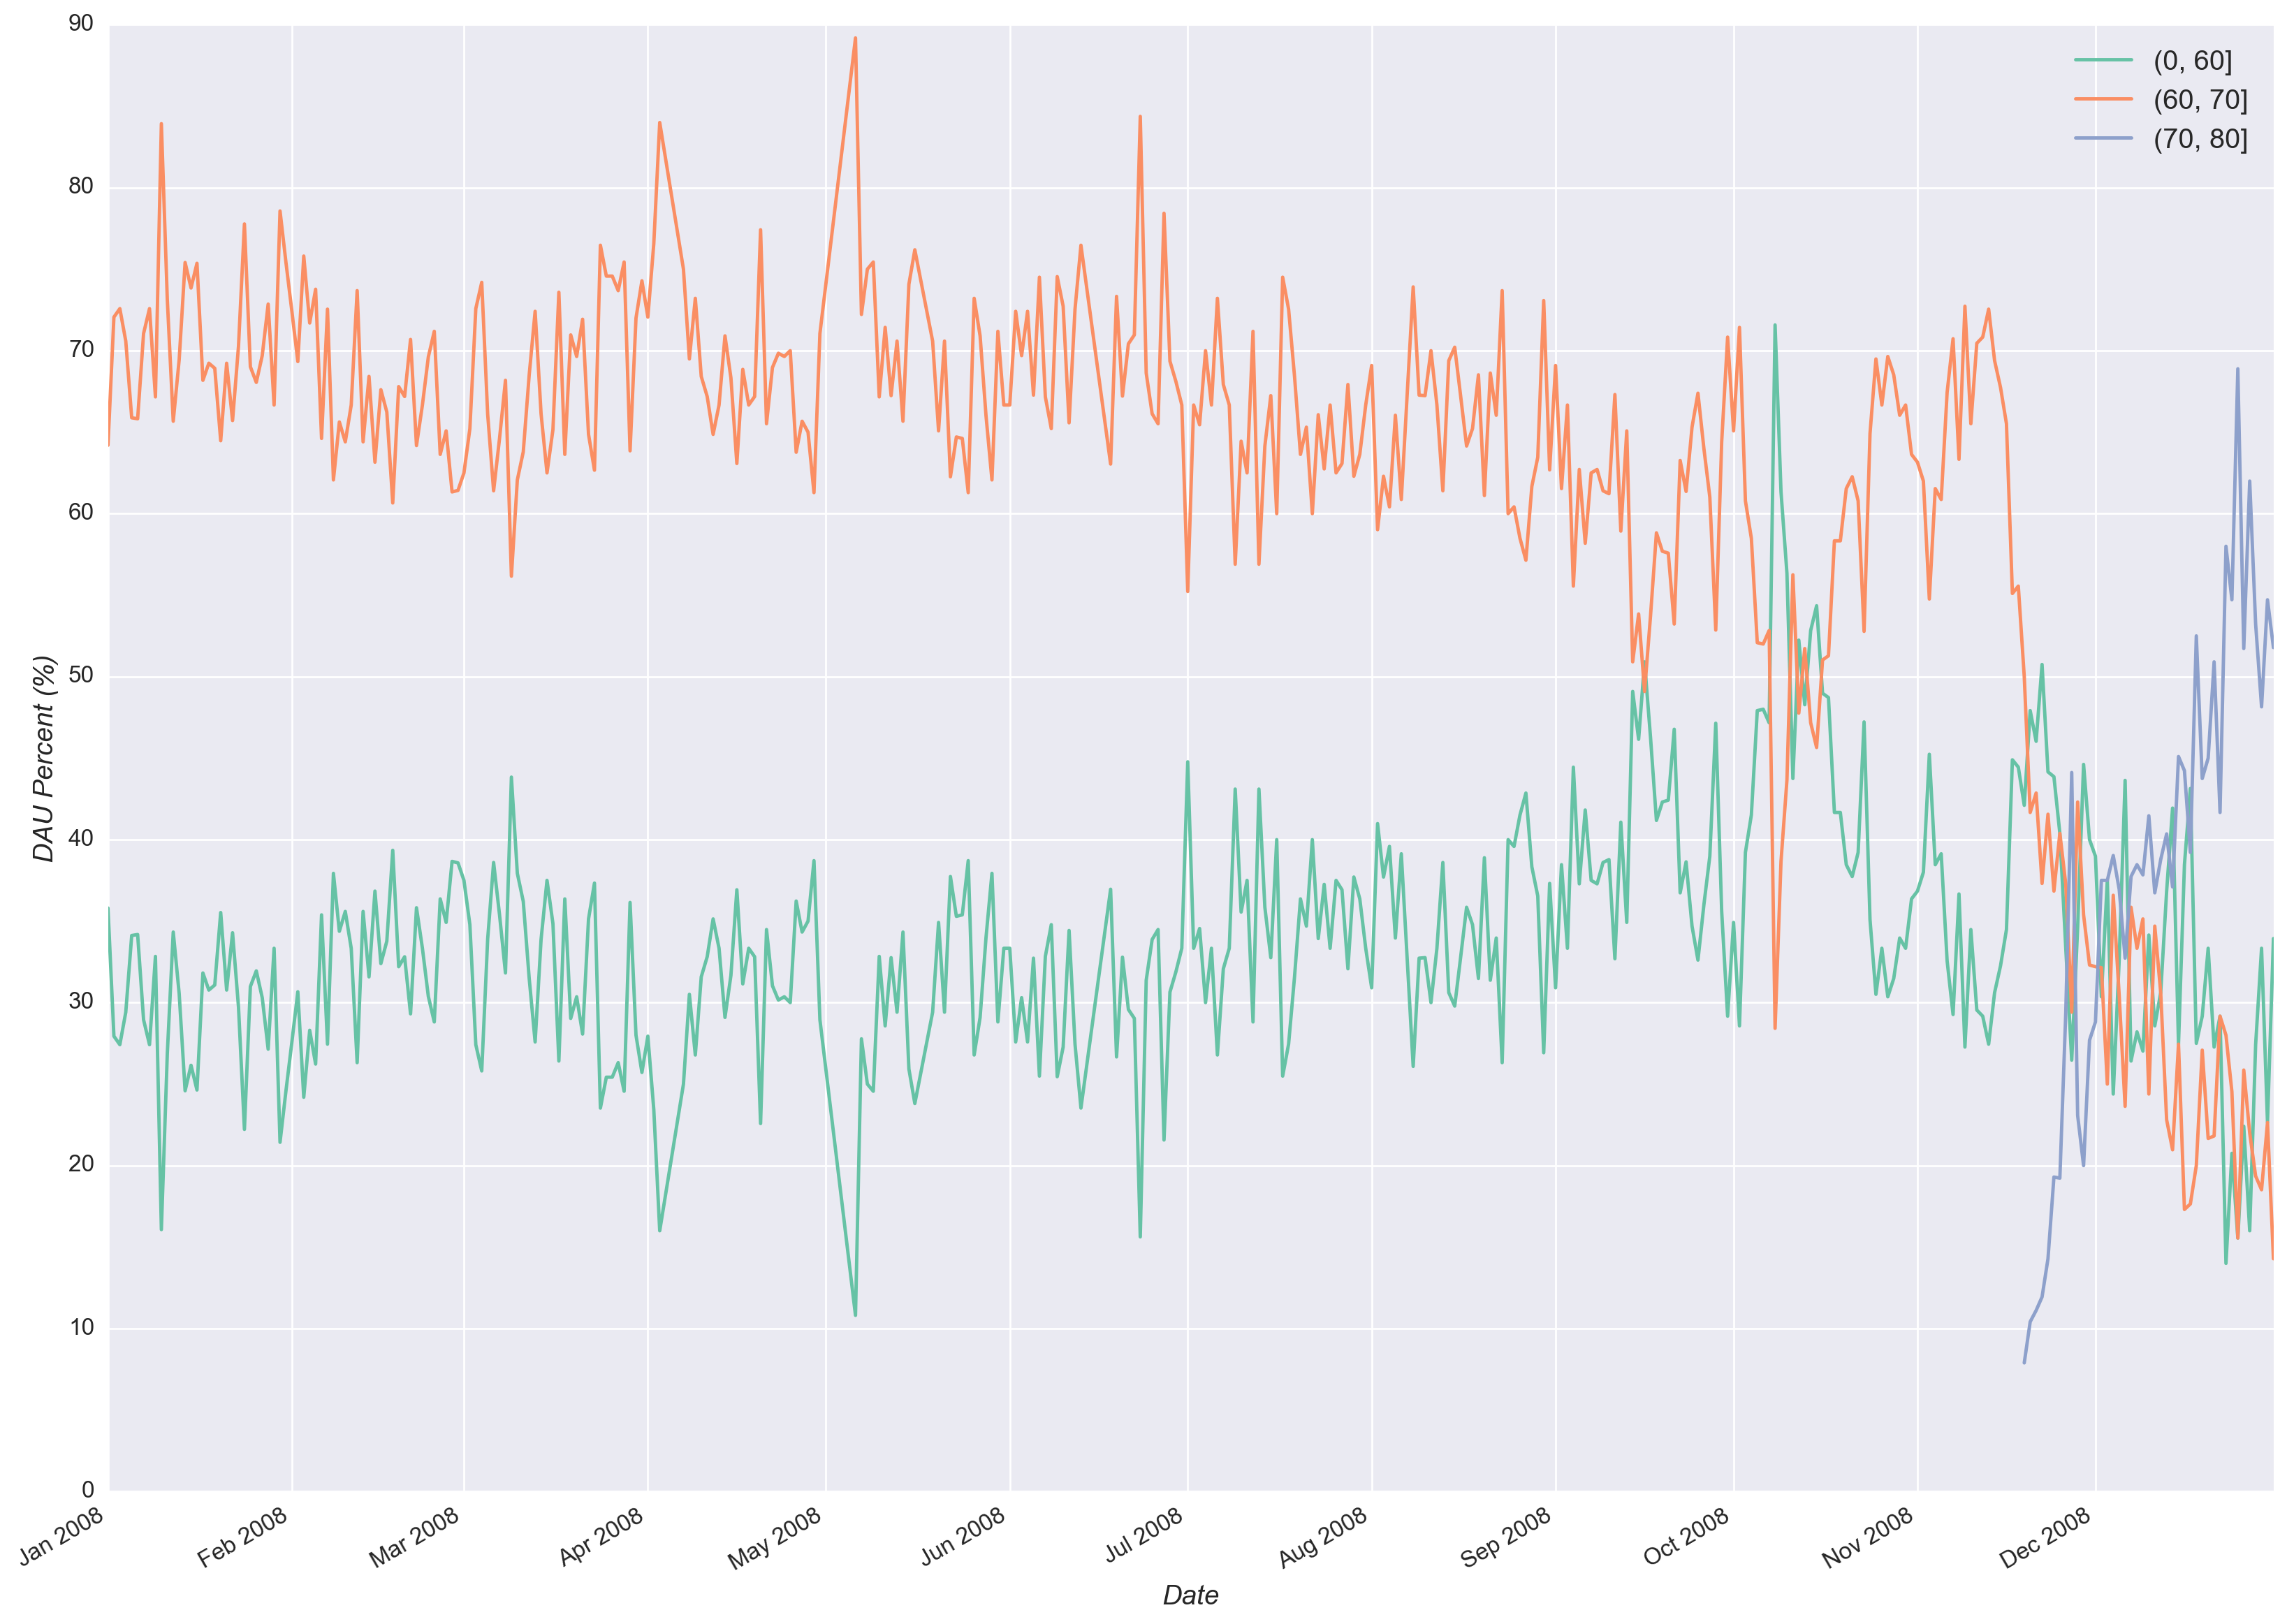

In [885]:
# Plot DAU percent
fig, ax = plt.subplots(1,1, figsize=(20,15))


levels=list(dau_level['level_range'].unique())

for i,item in enumerate(levels):
    temp=dau_level[dau_level['level_range']==item]
    temp.set_index('date',inplace=True)
    temp.loc[:,['percent_dau']].plot(color=colors[i],ax=ax)

ax.legend(levels,loc="best",fontsize='x-large')


# # plt.setp(labels, rotation=90) 
ax.set_ylabel("DAU Percent (%)",style='italic',fontsize=14)
ax.set_xlabel("Date",style='italic',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

pyplot.show()

### The following code prepares the data to plot sessions/DAU, a metric that indicates engagement

In [886]:
# Count unique users by date and range of levels
sess_dau_level=ww_char_sub.groupby(['date','level_range',])['char'].nunique().reset_index()
sess_dau_level=sess_dau_level.rename(columns={'char':'dau'})
sess_dau_level.head()

,date,level_range,dau
0,2008-01-01,"(0, 60]",29
1,2008-01-01,"(60, 70]",52
2,2008-01-02,"(0, 60]",19
3,2008-01-02,"(60, 70]",49
4,2008-01-03,"(0, 60]",17


In [887]:
# Count all users by date and range of levels
temp=ww_char_sub.groupby(['date','level_range',])['char'].count().reset_index()
temp=temp.rename(columns={'char':'sessions'})
temp.head()

,date,level_range,sessions
0,2008-01-01,"(0, 60]",399
1,2008-01-01,"(60, 70]",1252
2,2008-01-02,"(0, 60]",240
3,2008-01-02,"(60, 70]",1072
4,2008-01-03,"(0, 60]",179


In [888]:
# Add column of count of all users by date and range of levels to the dataframe with the count of unique users by date
# and range of levels
sess_dau_level['level_date']=sess_dau_level['level_range'].astype(str).str.cat(sess_dau_level['date'].astype(str),sep=',')
temp['level_date']=temp['level_range'].astype(str).str.cat(temp['date'].astype(str),sep=',')
temp=temp.loc[:,['level_date','sessions']]

print sess_dau_level.shape
sess_dau_level=sess_dau_level.merge(temp,how='left',on="level_date")
print sess_dau_level.shape

(747, 4)
(747, 5)


In [889]:
# Calculate sessions per DAU
sess_dau_level.loc[:,'sessionsperdau']=(sess_dau_level['sessions']*1.0)/sess_dau_level['dau']

In [890]:
# Inspect
sess_dau_level.head()

,date,level_range,dau,level_date,sessions,sessionsperdau
0,2008-01-01,"(0, 60]",29,"(0, 60],2008-01-01",399,13.758621
1,2008-01-01,"(60, 70]",52,"(60, 70],2008-01-01",1252,24.076923
2,2008-01-02,"(0, 60]",19,"(0, 60],2008-01-02",240,12.631579
3,2008-01-02,"(60, 70]",49,"(60, 70],2008-01-02",1072,21.877551
4,2008-01-03,"(0, 60]",17,"(0, 60],2008-01-03",179,10.529412


Plot comments:

Engagement with WOW or sessions per DAU appear relatively close together. Still, high levels have relatively high engagement, although show a consistent decline over time compared to the sinusoidal engagement with low levels. 

In [891]:
# Plot sessions/DAU
temp=pd.pivot_table(sess_dau_level, values='sessionsperdau', index=['date'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='date',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='Sessions per DAU',xlabel='Date',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

### The following code prepares the data to plot monthly active users (MAU)

In [892]:
# Count unique users by month and range of levels
mau_level=ww_char_sub.groupby(['month_int','level_range',])['char'].nunique().reset_index()

In [893]:
# Add a column to the mau_level dataframe that includes the sum of all unique users by month
print mau_level.shape
add=mau_level.groupby('month_int')['char'].agg({'char':np.sum}).reset_index()
add=add.rename(columns={'char':'percent_mau'})
mau_level=mau_level.merge(add,how='left',on="month_int")
print mau_level.shape

(26, 3)
(26, 4)


In [894]:
# Inspect
mau_level.head()

,month_int,level_range,char,percent_mau
0,1,"(0, 60]",175,261
1,1,"(60, 70]",86,261
2,2,"(0, 60]",169,251
3,2,"(60, 70]",82,251
4,3,"(0, 60]",159,241


In [895]:
# Calculate the percent of MAU out of all MAU for the month
mau_level.loc[:,'percent_mau']=(mau_level['char']*100.0)/mau_level['percent_mau']
mau_level=mau_level.rename(columns={'char':'mau'})

In [896]:
# Inspect
mau_level.head()

,month_int,level_range,mau,percent_mau
0,1,"(0, 60]",175,67.049808
1,1,"(60, 70]",86,32.950192
2,2,"(0, 60]",169,67.330677
3,2,"(60, 70]",82,32.669323
4,3,"(0, 60]",159,65.975104


Plot comments:

The count and percent of MAU's are greatest for the low levels (0-60). The most steady count of MAU over 2008 occurs for high levels (60-70), but the high levels (60-70) roughly show the inverse trend of low levels (0-60) for MAU percent over time. 

In [899]:
# Plot MAU by range of levels
temp=pd.pivot_table(mau_level, values='mau', index=['month_int'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='month_int',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='MAU Count',xlabel='Month',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

In [897]:
# Plot MAU percent by range of levels
temp=pd.pivot_table(mau_level, values='percent_mau', index=['month_int'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='month_int',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='MAU Percent (%)',xlabel='Month',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

### The following code prepares the data to plot DAU/MAU, or stickiness of game

In [900]:
# Add the MAU column to the dataframe including the DAU grouped by range of levels
mau_level_temp=mau_level.loc[:,['month_int','level_range','mau']]

mau_level_temp['level_month']=mau_level_temp['level_range'].astype(str).str.cat(mau_level_temp['month_int'].astype(str),sep=',')

mau_level_temp=mau_level_temp.loc[:,['level_month','mau']]

dau_level.loc[:,'month_int']=dau_level['date'].dt.month
dau_level_temp=dau_level.loc[:,['date','level_range','dau','month_int']]

dau_level_temp['level_month']=dau_level_temp['level_range'].astype(str).str.cat(dau_level_temp['month_int'].astype(str),sep=',')

print dau_level_temp.shape
dau_level_temp=dau_level_temp.merge(mau_level_temp,how='left',on="level_month")
print dau_level_temp.shape

(747, 5)
(747, 6)


In [901]:
# Inspect
dau_level_temp.head()

,date,level_range,dau,month_int,level_month,mau
0,2008-01-01,"(0, 60]",29,1,"(0, 60],1",175
1,2008-01-01,"(60, 70]",52,1,"(60, 70],1",86
2,2008-01-02,"(0, 60]",19,1,"(0, 60],1",175
3,2008-01-02,"(60, 70]",49,1,"(60, 70],1",86
4,2008-01-03,"(0, 60]",17,1,"(0, 60],1",175


In [902]:
# Calculate percent of DAU/MAU
dau_level_temp.loc[:,'percent_dau_mau']=(dau_level_temp['dau']*100.0)/dau_level_temp['mau']

In [903]:
# Inspect
dau_level_temp.head()

,date,level_range,dau,month_int,level_month,mau,percent_dau_mau
0,2008-01-01,"(0, 60]",29,1,"(0, 60],1",175,16.571429
1,2008-01-01,"(60, 70]",52,1,"(60, 70],1",86,60.465116
2,2008-01-02,"(0, 60]",19,1,"(0, 60],1",175,10.857143
3,2008-01-02,"(60, 70]",49,1,"(60, 70],1",86,56.976744
4,2008-01-03,"(0, 60]",17,1,"(0, 60],1",175,9.714286


Plot comments:

The stickiness of users (DAU/MAU Percent) is highest for high levels (60-80) compared to low levels (0-60), although much more volatile. 

In [904]:
# Plot DAU/MAU by range of levels
temp=pd.pivot_table(dau_level_temp, values='percent_dau_mau', index=['date'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='date',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='DAU/MAU Percent (%)',xlabel='Date',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

### The following code prepares the data to plot retention

In [905]:
# Count unique users by install date and DSI
retention_group=ww_char_sub.groupby(['beg_date','dsi',])['char'].nunique().reset_index()

retention_group=retention_group.rename(columns={'char':'yes'})

In [906]:
# Inspect
retention_group.head()

,beg_date,dsi,yes
0,2008-01-01,0,81
1,2008-01-01,1,50
2,2008-01-01,2,43
3,2008-01-01,3,50
4,2008-01-01,4,54


In [907]:
# Add to retention dataframe count of unique users when dsi is equal to 0 
no=retention_group.loc[retention_group['dsi']==0,['beg_date','yes']]
no=no.rename(columns={'yes':'no'})

print retention_group.shape
retention_group=retention_group.merge(no, how="left", on="beg_date")
print retention_group.shape

(8761, 3)
(8761, 4)


In [908]:
# For all user with the same beginning date, calculate the difference of the count of unique users when the dsi is 
# equal to 0 and count of unique users when dsi is equal to or greater than 0
retention_group.loc[:,'no']=retention_group['no']-retention_group['yes']

In [909]:
# For each of the unique beginning dates, calculate the size of retained and churned users
retention_group.loc[:,'size']=retention_group['no']+retention_group['yes']

In [910]:
# Inspect
retention_group.head()

,beg_date,dsi,yes,no,size
0,2008-01-01,0,81,0,81
1,2008-01-01,1,50,31,81
2,2008-01-01,2,43,38,81
3,2008-01-01,3,50,31,81
4,2008-01-01,4,54,27,81


In [911]:
# Calculate the sum of all retained and churned users by dsi
retention=retention_group.groupby(['dsi'])['yes','no'].sum().reset_index()

In [912]:
# Inspect
retention.head()

,dsi,yes,no
0,0,1121,0
1,1,227,425
2,2,187,392
3,3,161,282
4,4,172,317


In [913]:
# Caculate the sum of the retained and churned users for dsi>0 and calculate percent retained
retention.loc[:,'size']=retention['yes']+retention['no']
retention.loc[:,'percent_ret']=(retention['yes']*100.0)/retention['size']
retention=retention.loc[retention['dsi']>0,:]

In [914]:
# Inspect
retention.head()

,dsi,yes,no,size,percent_ret
1,1,227,425,652,34.815951
2,2,187,392,579,32.297064
3,3,161,282,443,36.343115
4,4,172,317,489,35.173824
5,5,153,297,450,34.000000


Plot comments:

Sharp declines in retention count occur within the first 100 DSI. A consistent decline in retention percent is also observed over 2008, dropping roughly by half. 

Significant dips in retention count and retention percent occur just before and from 100-200 DSI.   

In [915]:
# Plot retention count over time
temp=retention.loc[:,['dsi','yes']]

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='dsi',y=['yes'], ylabel='Retention Count',xlabel='DSI',legend=False,plot_width=900, plot_height=700,tools=TOOLS,color='green')

show(p)

In [916]:
# Plot retention percent over time
temp=retention.loc[:,['dsi','percent_ret']]

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='dsi',y=['percent_ret'], ylabel='Retention Percent (%)',xlabel='DSI',legend=False,plot_width=900, plot_height=700,tools=TOOLS,color='green')

show(p)

### The following code prepares the data to plot retention by range of levels

In [917]:
# Count unique users by range of levels, beginning date, and dsi
retention_group_level=ww_char_sub.groupby(['level_range','beg_date','dsi',])['char'].nunique().reset_index()
retention_group_level=retention_group_level.rename(columns={'char':'yes'})

In [918]:
# Inpsect
retention_group_level.head()

,level_range,beg_date,dsi,yes
0,"(0, 60]",2008-01-01,0,29
1,"(0, 60]",2008-01-01,1,11
2,"(0, 60]",2008-01-01,2,6
3,"(0, 60]",2008-01-01,3,7
4,"(0, 60]",2008-01-01,4,13


In [919]:
# Add to retention dataframe count of unique users when dsi is equal to 0 
retention_group_level.loc[:,'level_date']=retention_group_level['level_range'].astype(str).str.cat(retention_group_level['beg_date'].astype(str),sep=',')

no=retention_group_level.loc[retention_group_level['dsi']==0,['level_date','yes']]
no=no.rename(columns={'yes':'no'})

print retention_group_level.shape
retention_group_level=retention_group_level.merge(no, how="left", on="level_date")
print retention_group_level.shape

(9773, 5)
(9773, 6)


In [920]:
# Inspect
retention_group_level.head()

,level_range,beg_date,dsi,yes,level_date,no
0,"(0, 60]",2008-01-01,0,29,"(0, 60],2008-01-01",29.0
1,"(0, 60]",2008-01-01,1,11,"(0, 60],2008-01-01",29.0
2,"(0, 60]",2008-01-01,2,6,"(0, 60],2008-01-01",29.0
3,"(0, 60]",2008-01-01,3,7,"(0, 60],2008-01-01",29.0
4,"(0, 60]",2008-01-01,4,13,"(0, 60],2008-01-01",29.0


In [921]:
# For all user with the same beginning date, calculate the difference of the count of unique users when the dsi is 
# equal to 0 and count of unique users when dsi is equal to or greater than 0
# For each of the unique beginning dates, calculate the size of retained and churned users
retention_group_level.loc[:,'no']=retention_group_level['no']-retention_group_level['yes']
retention_group_level.loc[:,'size']=retention_group_level['no']+retention_group_level['yes']

In [922]:
# Inspect
retention_group_level.head()

,level_range,beg_date,dsi,yes,level_date,no,size
0,"(0, 60]",2008-01-01,0,29,"(0, 60],2008-01-01",0.0,29.0
1,"(0, 60]",2008-01-01,1,11,"(0, 60],2008-01-01",18.0,29.0
2,"(0, 60]",2008-01-01,2,6,"(0, 60],2008-01-01",23.0,29.0
3,"(0, 60]",2008-01-01,3,7,"(0, 60],2008-01-01",22.0,29.0
4,"(0, 60]",2008-01-01,4,13,"(0, 60],2008-01-01",16.0,29.0


In [923]:
# Calculate the sum of all retained and churned users by range of levels and dsi
retention_level=retention_group_level.groupby(['level_range','dsi'])['yes','no'].sum().reset_index()

In [924]:
# For each range of levels, caculate the sum of the retained and churned users for dsi>0 and calculate percent retained
retention_level.loc[:,'size']=retention_level['yes']+retention_level['no']
retention_level.loc[:,'percent_ret']=(retention_level['yes']*100.0)/retention_level['size']
retention_level=retention_level.loc[retention_level['dsi']>0,:]

Plot comments:

The highest drop in retention count occurs in the lowest levels (0-60) around the first 20 DSI. Retention count continues to drop at the highest rate for the lowest levels until 100 DSI. In contrast, retention percent appears to drop the most for high levels (60-70) over most of the 2008 year. 

The significant dips in retention count and retention percent as observed above occurs due to dips in retention count and retention percent at high levels (60-70).   

In [926]:
# Plot retention count over time for each range of levels
temp=pd.pivot_table(retention_level, values='yes', index=['dsi'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='dsi',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='Retention Count',xlabel='DSI',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

In [927]:
# Plot retention percent over time for each range of levels
temp=pd.pivot_table(retention_level, values='percent_ret', index=['dsi'], columns=['level_range']).reset_index()

TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"

p=TimeSeries(data=temp,x='dsi',y=['(0, 60]','(60, 70]','(70, 80]'], ylabel='Retention Percent (%)',xlabel='DSI',legend=True,plot_width=900, plot_height=700,tools=TOOLS,color=['green','orange','blue'])

show(p)

### The following code prepares the data to plot the number of unique users who have compledted each level vs. level

In [928]:
# Count unique users by level
levels_uplayers=ww_char_sub.groupby(['level'])['char'].nunique().reset_index()

In [929]:
# Inspect
levels_uplayers.head()

,level,char
0,1,600
1,2,333
2,3,261
3,4,258
4,5,238


Plot comments:

The count of unique users continuously declines from 0 to 80 levels, except for a non-continuous jump around level 56. This jump should be investigated further by investigating changes made at that level over time. 

In [931]:
# Plot the number of unique users who have compledted each level vs. level
TOOLS="pan,wheel_zoom,box_zoom,reset,resize,save,crosshair,box_select"
p=Scatter(levels_uplayers,x='level',y='char',xlabel="Level",ylabel="Unique Users",tools=TOOLS)
show(p)